In [1]:
import sys,array
from ROOT import TFile, TCanvas
import root_numpy as rn
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'bold'

/Library/Python/2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.8.0rc1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [35]:
stage='sel2'

f = '/Volumes/UBooNEDataMCC8/MCC8_2/AnaFiles/MCBNBCos/backgrounds_%s.root'%stage
on ='/Volumes/UBooNEDataMCC8/MCC8_2/AnaFiles/OnBeam/backgrounds_%s.root'%stage
off='/Volumes/UBooNEDataMCC8/MCC8_2/AnaFiles/OffBeam/backgrounds_%s.root'%stage

t = rn.root2array(f,treename='tree')
df = pd.DataFrame(t)

a = rn.root2array(on,treename='tree')
df0 = pd.DataFrame(a)

b = rn.root2array(off,treename='tree')
df1 = pd.DataFrame(b)

In [36]:
print df0.shape, df1.shape, df.shape

(6183, 23) (762, 23) (29879, 23)


In [37]:
cos_v = df.query('bkgd_id == 1')
cc1pi0_v = df.query('bkgd_id == 2')
cc0pi0_v = df.query('bkgd_id == 3')
nc1pi0_v = df.query('bkgd_id == 4')
nc0pi0_v = df.query('bkgd_id == 5')
oth_v = df.query('bkgd_id == 6')

#print cos_v.shape[0] + nc_v.shape[0] + mult_v.shape[0] + sig_v.shape[0] + ccoth_v.shape[0] + test_v.shape[0]

colors_tst = ['purple','yellow','lime','green','lightskyblue','salmon'] #magenta','tan']
labels_tst = ['Other','Cosmic','NC 1-$\pi^0$','NC 0-$\pi^0$','CC 0-$\pi^0$','Signal']

In [38]:
tot_on = 543584 #541554 #525613
tot_off = 301061 #218466 #379202
tot_bnbcos = 232250 #384200 #101600

scale_intime = 10.279 
int_per_1e20POT = 99035.2 
dataPOT = 0.495 * (tot_on) / 567157 #547616  
mcbnbcos_POT = float(tot_bnbcos)/int_per_1e20POT 

off_to_on = 1.23 * (400675./tot_off) * (tot_on/567157.)
mc_to_onbeam = dataPOT/mcbnbcos_POT
print "POTS : ", dataPOT, mcbnbcos_POT 
print "MC to OnBeam : ", mc_to_onbeam
print "Off to OnBeam: ",off_to_on

var = 'mu_startx'

oth_w = [ mc_to_onbeam for i in xrange(len(oth_v[var].values)) ] 
cos_w = [ mc_to_onbeam for i in xrange(len(cos_v[var].values)) ] 
nc0pi0_w = [ mc_to_onbeam for i in xrange(len(nc0pi0_v[var].values)) ] 
nc1pi0_w = [ mc_to_onbeam for i in xrange(len(nc1pi0_v[var].values)) ] 
cc0pi0_w = [ mc_to_onbeam for i in xrange(len(cc0pi0_v[var].values)) ] 
sig_w = [ mc_to_onbeam for i in xrange(len(cc1pi0_v[var].values)) ] 

weights = [oth_w,cos_w,nc1pi0_w,nc0pi0_w,cc0pi0_w,sig_w]

all_w = [ mc_to_onbeam for i in xrange(len(df[var].values)) ] 

POTS :  0.474426093657 2.34512577346
MC to OnBeam :  0.202303048743
Off to OnBeam:  1.56893960342


In [39]:
def makeOnOffPlots(var,xmin,xmax,nbins=20,xlabel=''):

    x_on, y_on = np.histogram(df0[var].values,bins=nbins,range=(xmin,xmax))
    x_off, y_off = np.histogram(df1[var].values,bins=nbins,range=(xmin,xmax))
    x_bnb, y_bnb = np.histogram(df[var].values,bins=nbins,range=(xmin,xmax))
    
    bins = (y_off[:-1] + y_off[1:])/2
    bin_width = bins[1]-bins[0]

    bnbcos_m = x_bnb * mc_to_onbeam 
    off_m = x_off*off_to_on
     
    err_on = np.sqrt(x_on)
    err_off = np.sqrt(x_off)
    err_mc = np.sqrt(bnbcos_m)
    
    plt.figure()
    fig,ax = plt.subplots(figsize=(8,6))
    ax.hist([oth_v[var].values,cos_v[var].values,nc1pi0_v[var].values,nc0pi0_v[var].values,\
          cc0pi0_v[var].values],bins=nbins,label=labels_tst[:-1],color=colors_tst[:-1],stacked=True,\
         range=(xmin,xmax),weights=weights[:-1],rwidth=bin_width,histtype='stepfilled')
    plt.bar(bins - bin_width/2,err_mc*2,bin_width,bottom = bnbcos_m - err_mc/2.,\
        alpha=0.5, color='r', linewidth=0,label='Monte Carlo')
    plt.errorbar(bins,off_m,xerr=bin_width/2,yerr=err_off,fmt='ro',label='OffBeam',markersize=6,lw=1.5)
    plt.errorbar(bins,x_on,xerr=bin_width/2,yerr=err_on,fmt='ko',label='OnBeam',markersize=6,lw=1.5)
    handles,labels = ax.get_legend_handles_labels()
    if var == 'mu_startx' or var == 'mu_starty' or var == 'mu_startz' or \
       var == 'mu_endx' or var == 'mu_endy' or var == 'mu_endz':
        plt.legend(handles=handles[::-1],fontsize=12,loc='upper left',bbox_to_anchor=(1,0.7))
    else:
        plt.legend(handles=handles[::-1],fontsize=12,loc=0) #,loc='upper left',bbox_to_anchor=(1,0.9))
    
    plt.grid(True)
    plt.xlabel(xlabel,fontsize=18,weight='bold')
    plt.ylabel('N Events',fontsize=18,weight='bold')
    plt.ylim(0)
    plt.xlim(xmin,xmax)
    plt.savefig('Plots/Physics_%s_onoffseparate_%s.png'%(stage,var))

In [40]:
def makePlots(var,xmin,xmax,nbins=20,xlabel=''):

    x_on, y_on = np.histogram(df0[var].values,bins=nbins,range=(xmin,xmax))
    x_off, y_off = np.histogram(df1[var].values,bins=nbins,range=(xmin,xmax))
    x_bnb, y_bnb = np.histogram(df[var].values,bins=nbins,range=(xmin,xmax))
    
    bins = (y_off[:-1] + y_off[1:])/2
    bin_width = bins[1]-bins[0]

    bnbcos_m = x_bnb * mc_to_onbeam 
    off_min_on_m = x_on - x_off*off_to_on

    off_min_on_m = [off_min_on_m[i] if off_min_on_m[i] >=0 else 0 for i in xrange(len(off_min_on_m)) ]

    err_on = np.sqrt(x_on)
    err_off = np.sqrt(x_off)
    err_data = np.sqrt(err_on * err_on + err_off * err_off)
    err_mc = np.sqrt(bnbcos_m)
    
    plt.figure()
    fig,ax = plt.subplots(figsize=(8,6))
    ax.hist([oth_v[var].values,cos_v[var].values,nc1pi0_v[var].values,nc0pi0_v[var].values,\
          cc0pi0_v[var].values],bins=nbins,label=labels_tst[:-1],color=colors_tst[:-1],stacked=True,\
         range=(xmin,xmax),weights=weights[:-1],rwidth=bin_width,histtype='stepfilled')
    #ax.hist([oth_v[var].values,cos_v[var].values,nc1pi0_v[var].values,nc0pi0_v[var].values,\
    #      cc0pi0_v[var].values,cc1pi0_v[var].values],bins=nbins,label=labels_tst,color=colors_tst,stacked=True,\
    #     range=(xmin,xmax),weights=weights,rwidth=bin_width,histtype='stepfilled')
    plt.bar(bins - bin_width/2,err_mc*2,bin_width,bottom = bnbcos_m - err_mc/2.,\
        alpha=0.5, color='r', linewidth=0,label='Monte Carlo')
    plt.errorbar(bins,off_min_on_m,xerr=bin_width/2,yerr=err_data,fmt='ko',label='On - OffBeam',markersize=6,lw=1.5)
    handles,labels = ax.get_legend_handles_labels()
    if var == 'mu_startx' or var == 'mu_starty' or var == 'mu_startz' or \
       var == 'mu_endx' or var == 'mu_endy' or var == 'mu_endz' or \
         var == 'vtx_x' or var == 'vtx_y' or var == 'vtx_z':
        plt.legend(handles=handles[::-1],fontsize=12,loc='upper left',bbox_to_anchor=(1,0.7))
    else:
        plt.legend(handles=handles[::-1],fontsize=12,loc=0) #,loc='upper left',bbox_to_anchor=(1,0.9))
    
    
    plt.grid(True)
    plt.xlabel(xlabel,fontsize=18,weight='bold')
    plt.ylabel('N Events',fontsize=18,weight='bold')
    plt.ylim(0)
    plt.xlim(xmin,xmax)
    plt.savefig('Plots/Physics_%s_%s.png'%(stage,var))

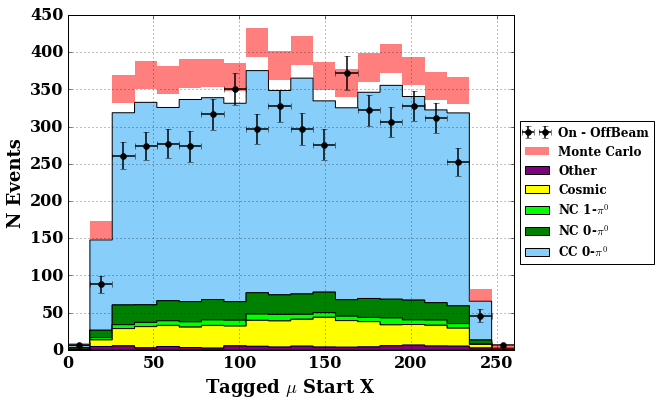

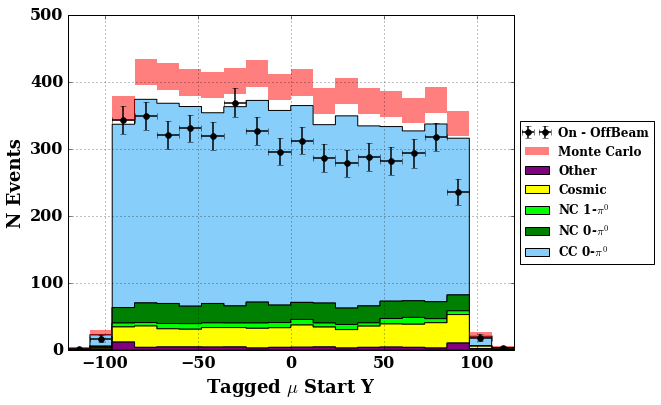

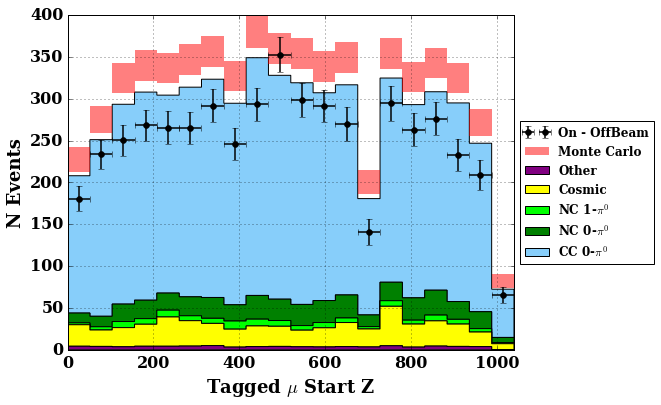

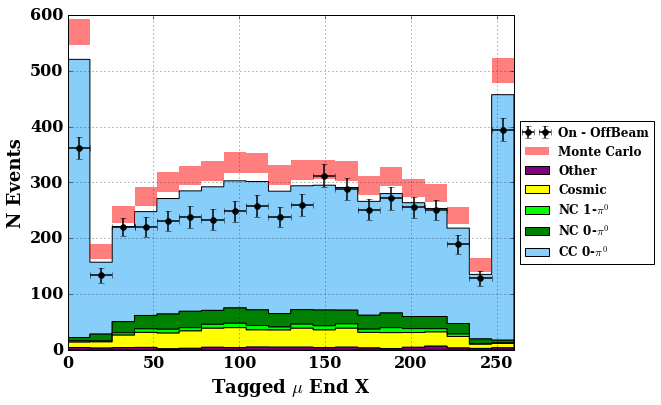

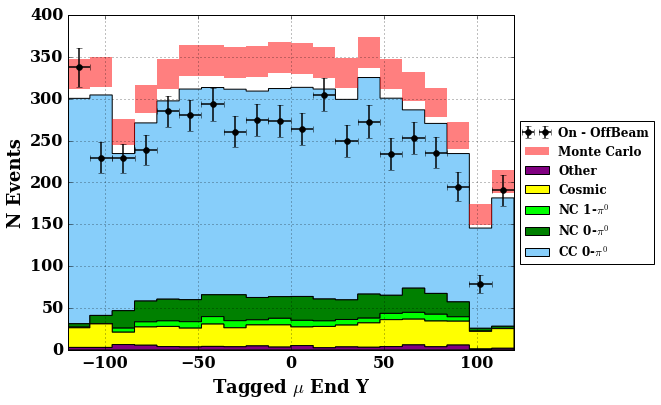

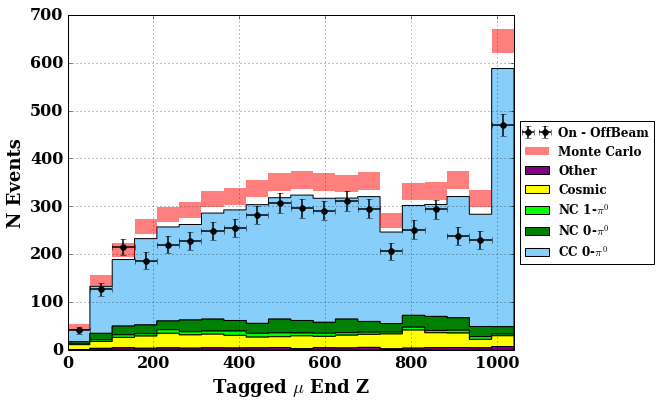

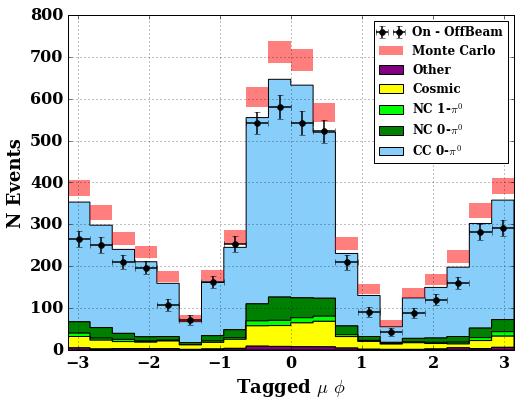

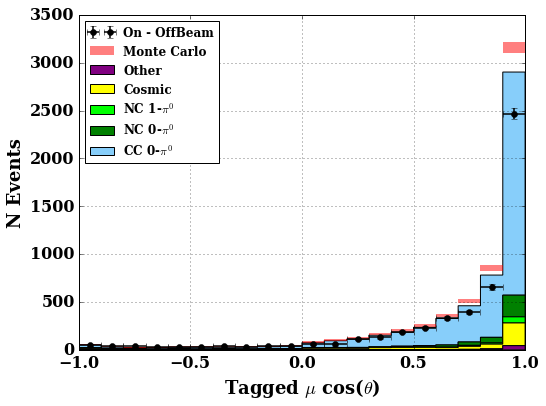

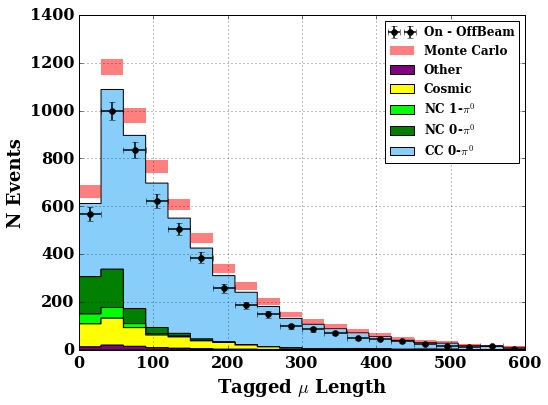

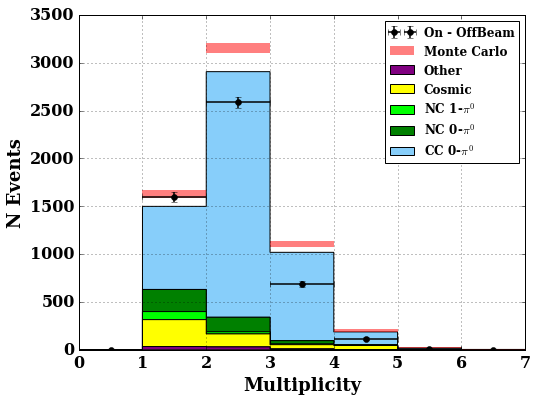

In [41]:
makePlots('mu_startx',0,260,xlabel='Tagged $\mu$ Start X')
makePlots('mu_starty',-120,120,xlabel='Tagged $\mu$ Start Y')
makePlots('mu_startz',0,1040,xlabel='Tagged $\mu$ Start Z')
makePlots('mu_endx',0,260,xlabel='Tagged $\mu$ End X')
makePlots('mu_endy',-120,120,xlabel='Tagged $\mu$ End Y')
makePlots('mu_endz',0,1040,xlabel='Tagged $\mu$ End Z')

makePlots('mu_phi',-3.14,3.14,xlabel='Tagged $\mu$ $\\phi$')
makePlots('mu_angle',-1,1,xlabel='Tagged $\mu$ cos($\\theta$)')
makePlots('mu_len',0,600,xlabel='Tagged $\mu$ Length')
makePlots('mult',0,7,nbins=7,xlabel='Multiplicity')

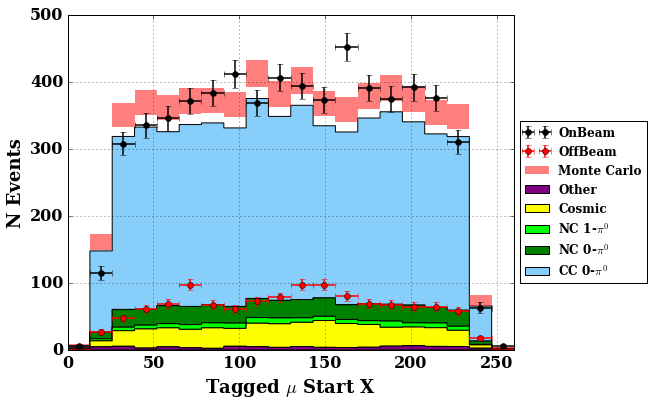

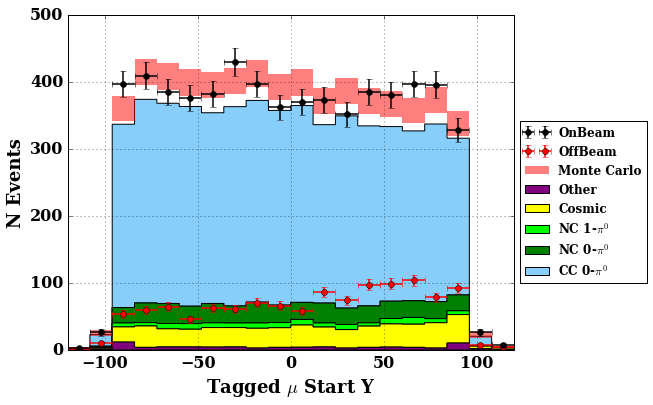

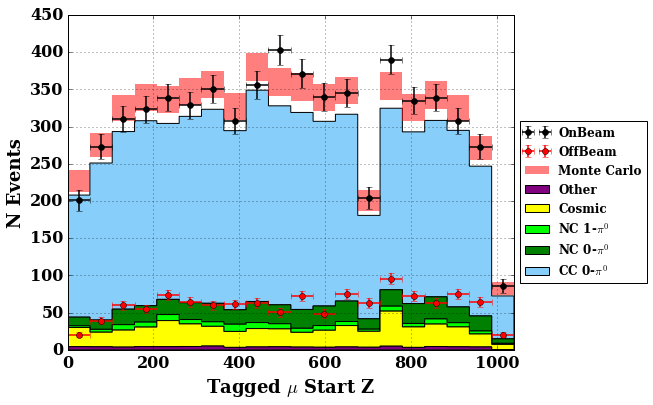

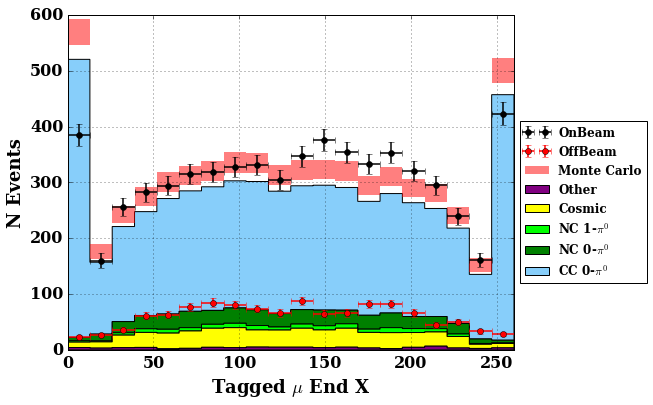

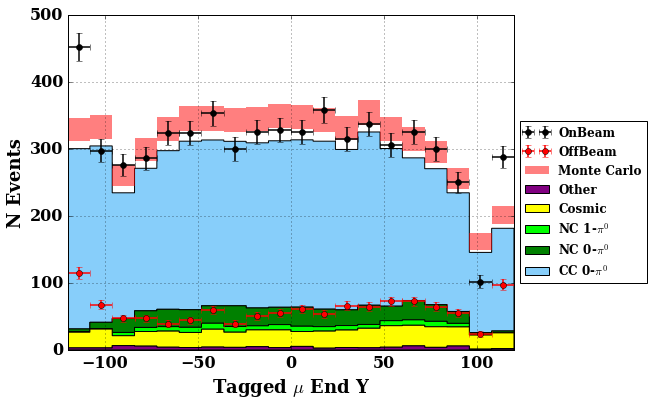

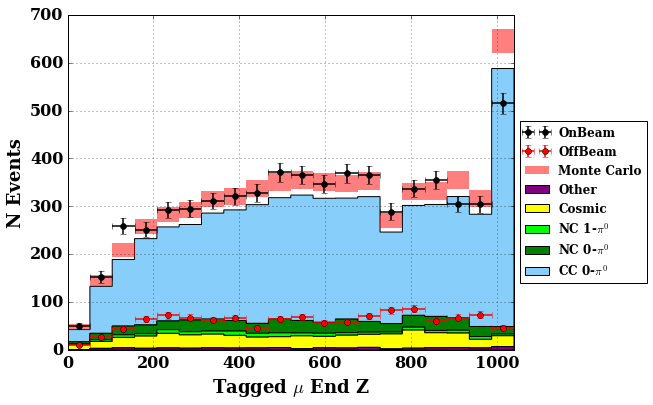

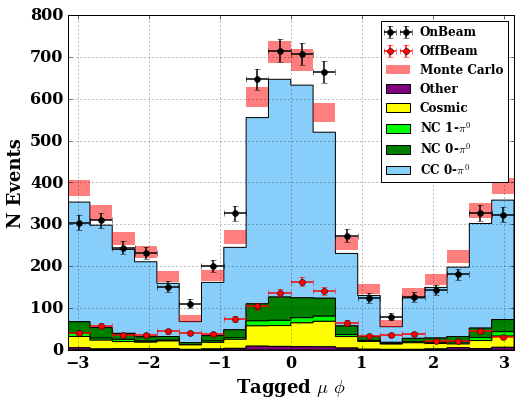

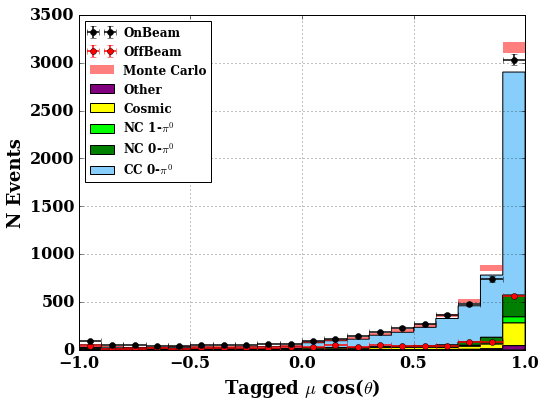

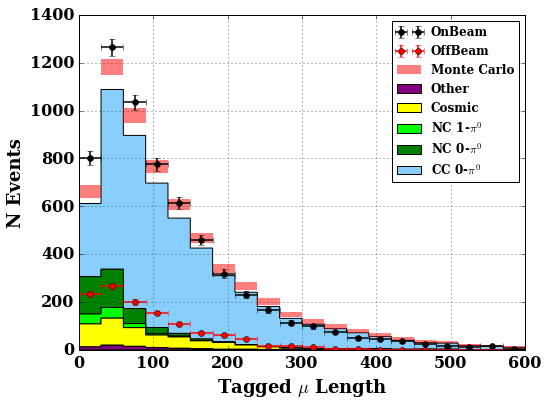

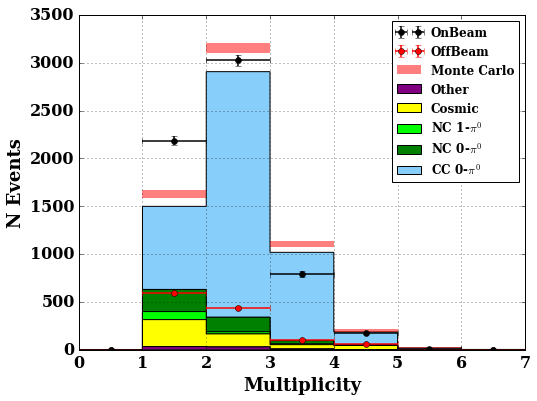

In [42]:
makeOnOffPlots('mu_startx',0,260,xlabel='Tagged $\mu$ Start X')
makeOnOffPlots('mu_starty',-120,120,xlabel='Tagged $\mu$ Start Y')
makeOnOffPlots('mu_startz',0,1040,xlabel='Tagged $\mu$ Start Z')
makeOnOffPlots('mu_endx',0,260,xlabel='Tagged $\mu$ End X')
makeOnOffPlots('mu_endy',-120,120,xlabel='Tagged $\mu$ End Y')
makeOnOffPlots('mu_endz',0,1040,xlabel='Tagged $\mu$ End Z')

makeOnOffPlots('mu_phi',-3.14,3.14,xlabel='Tagged $\mu$ $\\phi$')
makeOnOffPlots('mu_angle',-1,1,xlabel='Tagged $\mu$ cos($\\theta$)')
makeOnOffPlots('mu_len',0,600,xlabel='Tagged $\mu$ Length')
makeOnOffPlots('mult',0,7,nbins=7,xlabel='Multiplicity')

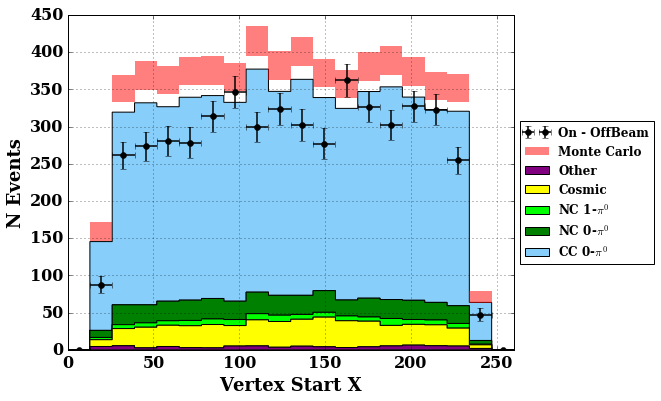

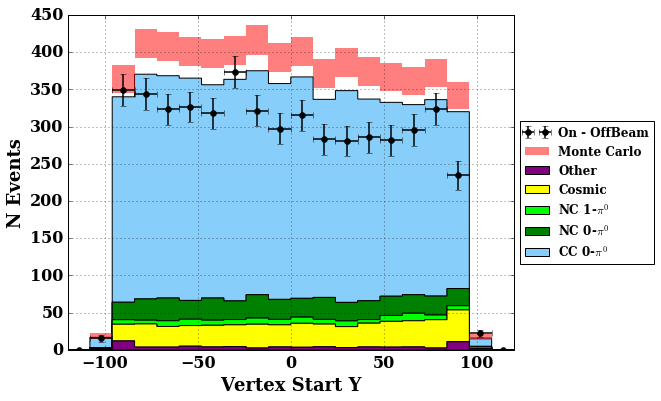

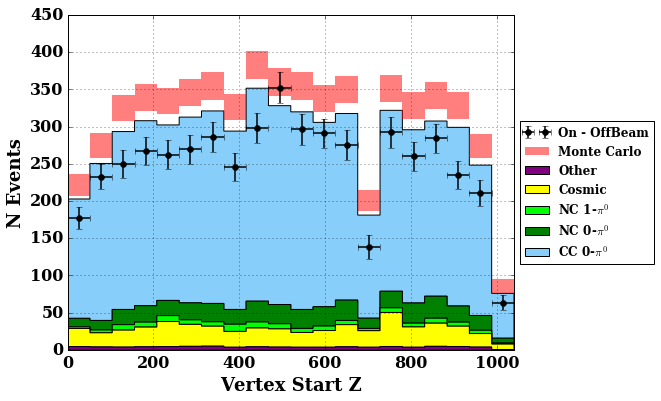

In [43]:
makePlots('vtx_x',0,260,xlabel='Vertex Start X')
makePlots('vtx_y',-120,120,xlabel='Vertex Start Y')
makePlots('vtx_z',0,1040,xlabel='Vertex Start Z')

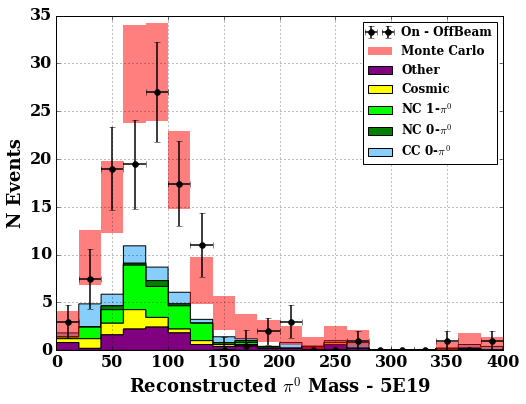

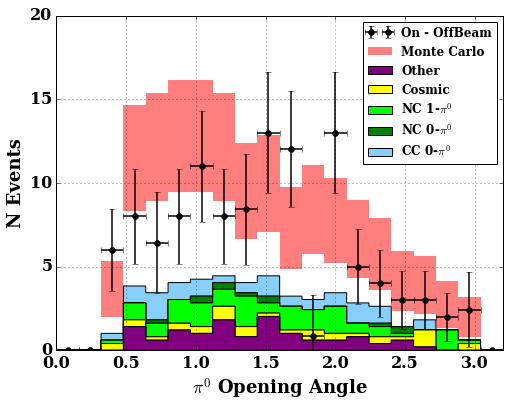

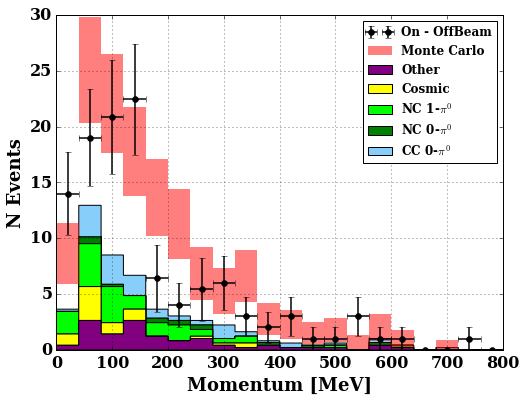

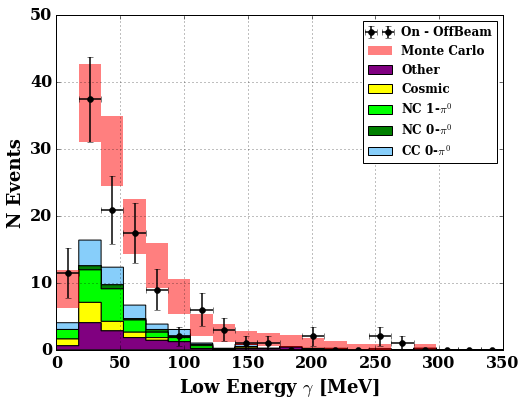

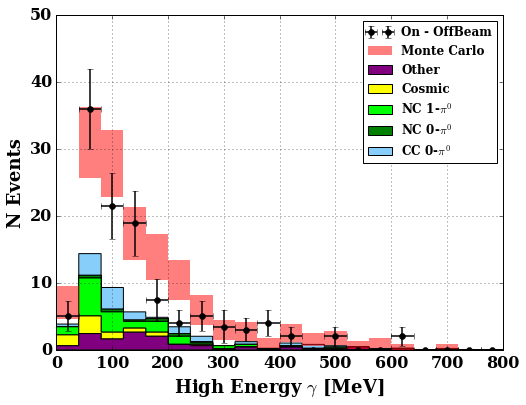

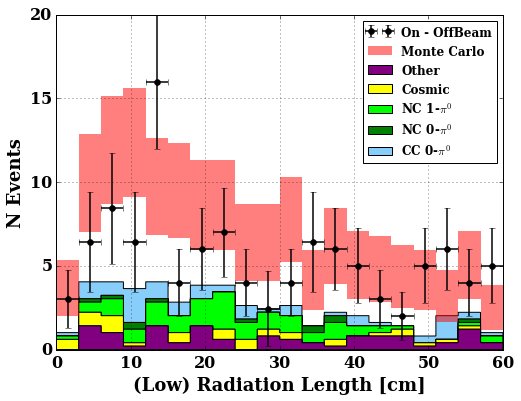

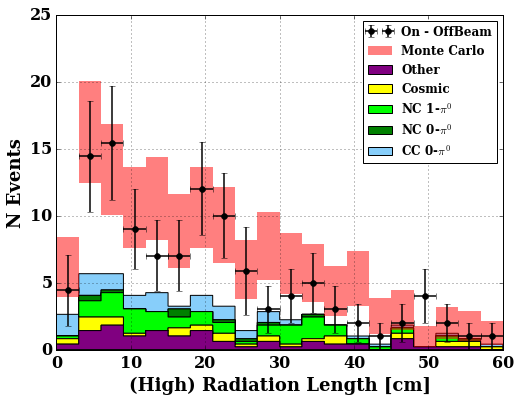

In [33]:
makePlots('pi0_mass',0,400,xlabel='Reconstructed $\pi^0$ Mass - 5E19')
makePlots('pi0_oangle',0,3.2,xlabel='$\pi^0$ Opening Angle')
makePlots('pi0_mom',0,800,xlabel='Momentum [MeV]')
makePlots('pi0_low_shrE',0,350,xlabel='Low Energy $\\gamma$ [MeV]')
makePlots('pi0_high_shrE',0,800,xlabel='High Energy $\\gamma$ [MeV]')
makePlots('pi0_low_radL',0,60,xlabel='(Low) Radiation Length [cm]')
makePlots('pi0_high_radL',0,60,xlabel='(High) Radiation Length [cm]')

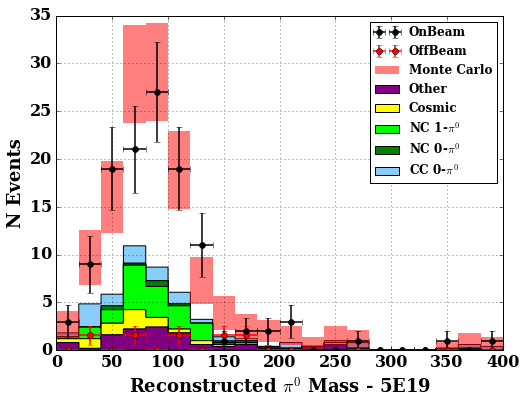

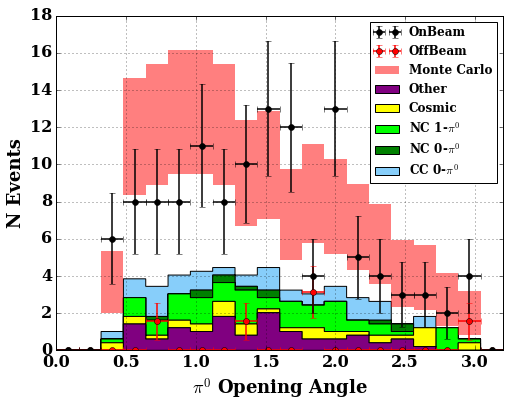

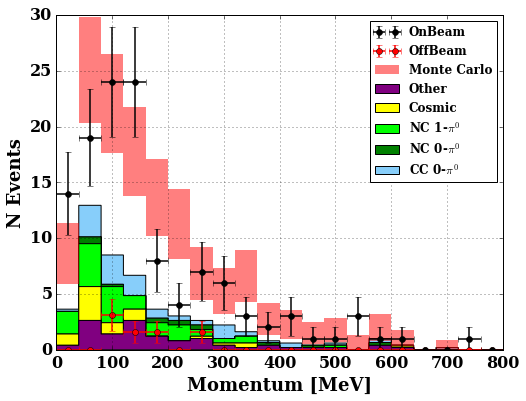

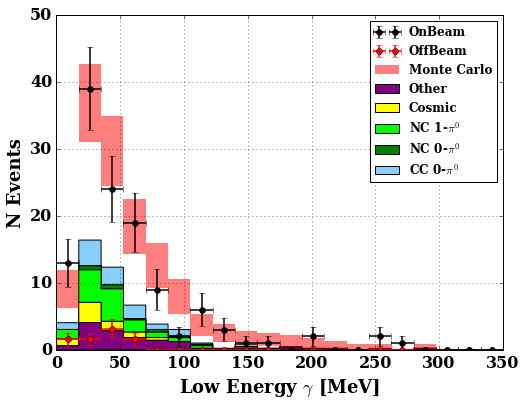

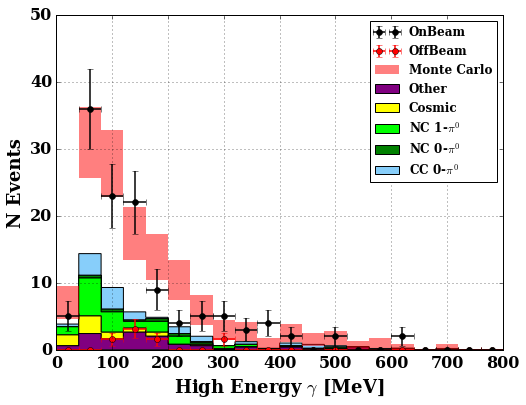

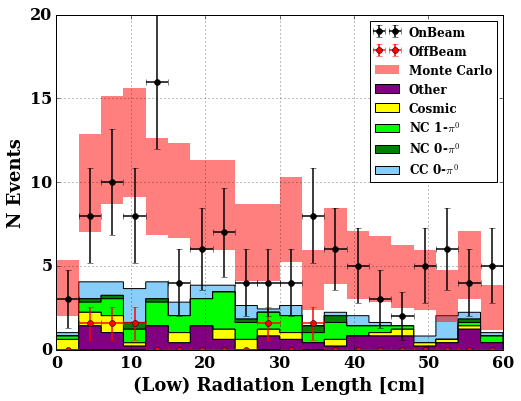

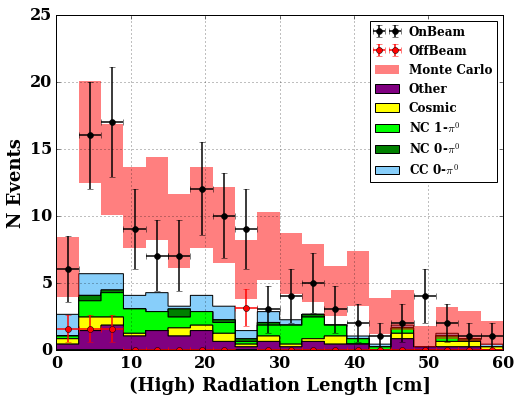

In [34]:
makeOnOffPlots('pi0_mass',0,400,xlabel='Reconstructed $\pi^0$ Mass - 5E19')
makeOnOffPlots('pi0_oangle',0,3.2,xlabel='$\pi^0$ Opening Angle')
makeOnOffPlots('pi0_mom',0,800,xlabel='Momentum [MeV]')
makeOnOffPlots('pi0_low_shrE',0,350,xlabel='Low Energy $\\gamma$ [MeV]')
makeOnOffPlots('pi0_high_shrE',0,800,xlabel='High Energy $\\gamma$ [MeV]')
makeOnOffPlots('pi0_low_radL',0,60,xlabel='(Low) Radiation Length [cm]')
makeOnOffPlots('pi0_high_radL',0,60,xlabel='(High) Radiation Length [cm]')